##1. Set up openai

In [8]:
!pip install openai matplotlib networkx

In [9]:
import openai
import json
import os
import glob
import random
import matplotlib.pyplot as plt
import networkx as nx #python package for networks
import numpy as np
from openai import OpenAI
from google.colab import userdata
from google.colab import drive , userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
apiKey = userdata.get('OpenAI.API')

# Create the OpenAI client
client = OpenAI(api_key=apiKey)

TypeError: Client.__init__() got an unexpected keyword argument 'proxies'

##2. Save State


In [ ]:
def save_game(group, currentLocation, locations, dungeonMap):
    filename = input("Enter the name of the save file: ")
    try:
        game_state = {
            'group': group.to_dict(),
            'current_location': currentLocation,
            'locations': {loc.name: loc.to_dict() for loc in locations},
            'dungeonMap': dungeonMap # Assuming locations is a list of Location instances
        }

        with open(filename + '.json', 'w') as f:
            json.dump(game_state, f, indent=4)

        print(f"Game saved successfully to {filename}")
    except Exception as e:
        print(f"Error saving game: {str(e)}")

def load_game():
    """Load the game state from a JSON file"""
    json_files = glob.glob('*.json')
    for file in json_files:
        print(file)

    filename = input("Enter the name of the save file to load: ")
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        group = Group.from_dict(data)
        print(f"Game loaded successfully from {filename}")
        return group
    except FileNotFoundError:
        print(f"No save file found at {filename}")
        return None
    except Exception as e:
        print(f"Error loading game: {str(e)}")
        return None

In [ ]:
class Character:
    def __init__(self, health=100, xp=0, inventory=None):
        if inventory is None:
            inventory = []
        self.health = health
        self.xp = xp
        self.inventory = inventory

class Location:
    def __init__(self, description, items=None, npcs=None):
        if items is None:
            items = []
        if npcs is None:
            npcs = []
        self.description = description
        self.items = items
        self.npcs = npcs

class GameState:
    def __init__(self):
        self.player = Player()
        self.locations = {}

##3. Character

In [ ]:
class Character:
    def __init__(self, name, char_class, description, status = True):
        self.name = name
        self.char_class = char_class
        self.status = status
        self.lvl_exp = 0
        self.lvl = self.lvl_exp // 100
        self.inventory = []

        if char_class == 'Fighter':
            self.hp = 95 + int(self.lvl * 2)
            self.atk = 85 + int(self.lvl * 5)
            self.intelligence = 60 + int(self.lvl * 1)
            self.dex = 70 + int(self.lvl * 2)
        elif char_class == 'Rogue':
            self.hp = 70
            self.atk = 75
            self.intelligence = 75
            self.dex = 90
        elif char_class == 'Mage':
            self.hp = 60
            self.atk = 75
            self.intelligence = 95
            self.dex =65
        self.description = description

    def add_exp(self, exp):
        self.lvl += exp // 100
        self.lvl_exp += exp % 100


    def damage_taken(self, damage):
        self.hp -= damage
        if self.hp <= 0:
            self.hp = 0
            self.status = False
            print(self.name + ' has died')
            group.members.remove(self)

    def display(self):
        print('Name: ' + self.name)
        print(' Description: ' + self.description)
        print(' Class: ' + self.char_class)
        print(' HP: ' + str(self.hp))
        print(' Attack: ' + str(self.atk))
        print(' Intelligence: ' + str(self.intelligence))
        print(' Dexterity: ' + str(self.dex))
        print(' Level: ' + str(self.lvl))


    def to_dict(self):
        """Convert character to dictionary for JSON serialization"""
        return {
            'name': self.name,
            'char_class': self.char_class,
            'description': self.description,
            'hp': self.hp,
            'atk': self.atk,
            'intelligence': self.intelligence,
            'dex': self.dex,
            'lvl': self.lvl,
            'lvl_exp': self.lvl_exp,
            'inventory': self.inventory
        }

    @classmethod
    def from_dict(cls, data):
        character = cls(data['name'], data['char_class'], data['description'])
        character.hp = data['hp']
        character.atk = data['atk']
        character.intelligence = data['intelligence']
        character.dex = data['dex']
        character.lvl = data['lvl']
        character.lvl_exp = data['lvl_exp']
        character.inventory = data['inventory']
        return character

class Group:
    def __init__(self, name, members, description):
        self.name = name
        self.description = description
        self.members = members
        self.inventory = []

    def display(self):
        print('Group Name: ' + self.name)
        print('Description: ' + self.description)
        for member in self.members:
            print(member.display())


    def to_dict(self):
        return {
            'name': self.name,
            'description': self.description,
            'members': [member.to_dict() for member in self.members]
        }

    @classmethod
    def from_dict(cls, data):
        members = [Character.from_dict(member_data) for member_data in data['members']]
        return cls(data['name'], members, data['description'])

def group_creation():
  class_choices = ['Fighter', 'Rogue', 'Mage']
  print('To start the game you need to make your group and characters!')
  group_name = input("What will be the name of your Adventuring Group? ")
  num_members = 0
  while(num_members < 1 or num_members > 10):
    num_members = int(input("How many members will be in your group? "))
    if(num_members < 1 or num_members > 10):
      print("Invalid number of members (Pick a number 1 through 10)")
  membs = []
  for x in range(num_members):
    name = input("What will be the name of character {}?".format(x + 1))
    char_class_num = 0
    while((char_class_num < 1 or char_class_num > 3) and char_class_num % 1 == 0):
      char_class_num = int(input("Choose a class (enter the number): \n  1. Fighter \n  2. Rogue \n  3. Mage \n"))
      if (char_class_num < 1 or char_class_num > 3) and char_class_num % 1 == 0:
        print("Invalid input")
    char_description = input("Describe your character: ")
    char_class = class_choices[int(char_class_num) - 1]
    membs.append(Character(name, char_class, char_description))
  group_description = input("Describe your group: ")
  return Group(group_name, membs, group_description)

##4. World/Dungeon Map

In [ ]:
# Creates location object and bidirectional connection between locations
class Location:
    def __init__(self, name):
        self.name = name
        self.connections = []

    def connect(self, otherLocation):
      if otherLocation not in self.connections:
        self.connections.append(otherLocation)
        otherLocation.connections.append(self)

    def to_dict(self):
      #Convert location to dictionary for JSON serialization
      return {
        'name': self.name,
        'connections': [conn.name for conn in self.connections]
      }

    @classmethod
    def from_dict(cls, data):
        location = cls(data['name'])
        location.connections = []  # Initialize connections as empty
        return location

# Creates World Map using networkx and matplotlib
class GameMap:
    def __init__(self):
        self.locations = {}
        self.graph = nx.Graph()

    # Adds location to location dictionary and node to networkX
    def addLocation(self, name):
        location = Location(name)
        self.locations[name] = location
        self.graph.add_node(name)

    # Adds edges between connecting locations
    def connectLocations(self, name1, name2):
        if name1 in self.locations and name2 in self.locations:
            loc1 = self.locations[name1]
            loc2 = self.locations[name2]
            loc1.connect(loc2)
            self.graph.add_edge(name1, name2)

    # Sets up node locations on matplotlib with networkX graph
    def drawMap(self, currentLocation=None):
        pos = {
            "Village": (0.5, 0),
            "Quests": (-0.5, 0.75),
            "Blacksmith": (-0.5, -0.75),
            "Apothecary": (-0.5, -0.25),
            "Dungeon": (1.5, 0)
        }

        # Plots matplotlib with size
        plt.figure(figsize=(6, 5))

        # Draws edges as connections
        nx.draw_networkx_edges(self.graph, pos)

        # Draws nodes as locations
        nx.draw_networkx_nodes(self.graph, pos,
                                 node_size=1700,
                                 node_color='lightgreen')
        # Draws location labels
        nx.draw_networkx_labels(self.graph, pos,
                                  font_size=10)

        # Marks current player location as orange
        if currentLocation and currentLocation in self.graph:
            nx.draw_networkx_nodes(self.graph, pos,
                                    nodelist=[currentLocation],
                                    node_color='orange', node_size=1700)

        # Plots World Map
        plt.title("World Map")
        plt.axis('off')
        plt.pause(0.001)

# Creates Dungeon Map as rows x cols grid map using matplotlib
class DungeonMap:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = self.generate()
        self.playerPos = self.Start()
        self.startPos = self.Start()
        self.exitPos = self.Exit()
        self.visited = set([self.playerPos])

    # Generates tiles
    def generate(self):
        grid = [['wall' for _ in range(self.cols)] for _ in range(self.rows)]

        current = (1, 1)

        # Labels initial tile R1
        grid[current[0]][current[1]] = 'R1'
        # Places room into stack
        stack = [current]
        roomCount = 1

        while stack:
            current = stack.pop()
            neighbors = [(current[0]+x, current[1]+y) for x, y in [(0,1),(1,0),(0,-1),(-1,0)]]
            random.shuffle(neighbors)
            for nextTile in neighbors:
                if (0 <= nextTile[0] < self.rows and 0 <= nextTile[1] < self.cols
                    and grid[nextTile[0]][nextTile[1]] == 'wall'):
                    grid[nextTile[0]][nextTile[1]] = f'R{roomCount+1}'
                    stack.append(nextTile)
                    roomCount += 1
                    break

        return grid

    # Sets starting tile at R1
    def Start(self):
        for i in range(self.rows):
            for j in range(self.cols):
                if self.grid[i][j] == 'R1':
                    return (i, j)
        return (0, 0)

    # Sets exit tile randomly at a valid tile that is not the start tile
    def Exit(self):
        valid = [(i, j) for i in range(self.rows) for j in range(self.cols)
                           if self.grid[i][j].startswith('R') and (i, j) != self.playerPos]
        exitPos = random.choice(valid)
        self.grid[exitPos[0]][exitPos[1]] = 'EXIT'
        return exitPos

    # Draws map with matplot lib as a 2D grid
    def drawMap(self):
        fig, ax = plt.subplots(figsize=(5, 5))

        # Sets colors of tiles depending on their descriptions
        for x in range(self.cols):
            for y in range(self.rows):
                if self.grid[y][x] == 'wall':
                    color = 'black'
                elif self.grid[y][x] == 'EXIT':
                    color = 'green'
                elif (y, x) in self.visited:
                    color = 'lightblue'
                else:
                    color = 'white'
                rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)
                if self.grid[y][x].startswith('R') or self.grid[y][x] == 'EXIT':
                    ax.text(x+0.5, y+0.5, self.grid[y][x], ha='center', va='center')

        # Creates player as a red circle on the grid
        player = plt.Circle((self.playerPos[1] + 0.5, self.playerPos[0] + 0.5), 0.3, color='red')
        ax.add_artist(player)

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Plots Dungeon Map
        plt.title("Dungeon Map")
        plt.axis('off')
        plt.pause(0.001)

    # Moves player either (up, down, left, right) depending on user input
    def movePlayer(self, direction):
        x, y = self.playerPos
        newPos = {
            'up': (x - 1, y),
            'down': (x + 1, y),
            'left': (x, y - 1),
            'right': (x, y + 1)
        }.get(direction, (x, y))

        # Updates new player position and marks as a visited node
        if (0 <= newPos[0] < self.rows and 0 <= newPos[1] < self.cols and
            (self.grid[newPos[0]][newPos[1]].startswith('R') or
             self.grid[newPos[0]][newPos[1]] == 'EXIT')):
            self.playerPos = newPos
            self.visited.add(newPos)
            return True
        return False

    def to_dict(self):
        """Convert dungeon map to dictionary for JSON serialization."""
        return {
            'rows': self.rows,
            'cols': self.cols,
            'grid': self.grid,
            'playerPos': self.playerPos,
            'startPos': self.startPos,
            'exitPos': self.exitPos,
            'visited': list(self.visited)  # Convert set to list for JSON serialization
        }

    @classmethod
    def from_dict(cls, data):
        """Create a DungeonMap instance from a dictionary."""
        dungeon_map = cls(data['rows'], data['cols'])
        dungeon_map.grid = data['grid']
        dungeon_map.playerPos = tuple(data['playerPos'])
        dungeon_map.startPos = tuple(data['startPos'])
        dungeon_map.exitPos = tuple(data['exitPos'])
        dungeon_map.visited = set(tuple(pos) for pos in data['visited'])  # Convert list back to set
        return dungeon_map

# Creates village with added location nodes and edges
def createVillage(gameMap):
    gameMap.addLocation("Village")
    gameMap.addLocation("Quests")
    gameMap.addLocation("Blacksmith")
    gameMap.addLocation("Apothecary")
    gameMap.addLocation("Dungeon")

    gameMap.connectLocations("Village", "Quests")
    gameMap.connectLocations("Village", "Blacksmith")
    gameMap.connectLocations("Village", "Apothecary")
    gameMap.connectLocations("Village", "Dungeon")

# Sets up Quests
class Quest:
    def processQuest():
        print("Welcome to the Quest Board")
        print("Select one of the following quests.")

        quest1 = "Find the mirror of enchantment."
        quest2 = "Defeat the vampire king."
        quest3 = "Discover the unexplored tomb."

        print(f"1. {quest1}")
        print(f"2. {quest2}")
        print(f"3. {quest3}")
        print("4. Save Game")

# Sets up blacksmith
class Blacksmith:
  def processBlacksmith():
    print("Welcome to the Blacksmith")
    print("Select one of the following 1, 2 or exit.")
    print(f"1. weapons")
    print(f"2. armour")

  def processWeapon():
      print("Select one of the following weapons.")
      print(f"1. Bow")
      print(f"2. Daggers")
      print(f"3. Staff")
      print(f"4. Sword")

  def processArmour():
      print("Select one of the following armours.")
      print(f"1. Heavy Armour")
      print(f"2. Light Armour")
      print(f"3. Apprentice Robes")
      print(f"4. Master Robes")

# Sets up Apothecary
class Apothecary:
  def processApothecary():
    print("Welcome to the Apothecary")
    print("Select one of the following 1, 2 or exit.")
    print(f"1. Small Potion")
    print(f"2. Large Potion")

##Main

Welcome to the Dungeon Master AI Agent!
Would you like to load a previous game? (yes/no): no
To start the game you need to make your group and characters!
What will be the name of your Adventuring Group? tacos
How many members will be in your group? 2
What will be the name of character 1?kim
Choose a class (enter the number): 
  1. Fighter 
  2. Rogue 
  3. Mage 
1
Describe your character: fancy
What will be the name of character 2?sam
Choose a class (enter the number): 
  1. Fighter 
  2. Rogue 
  3. Mage 
2
Describe your character: humble
Describe your group: well rounded

You are currently in: The Village


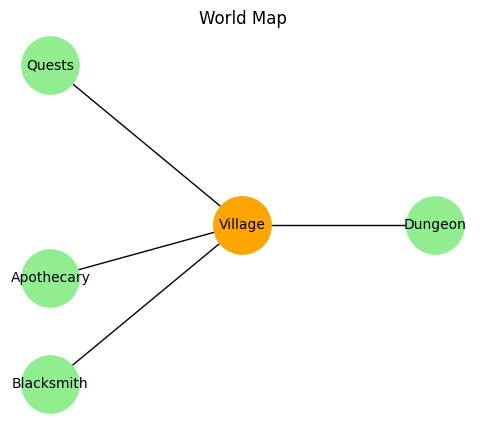

Where would you like to go?
dungeon

You are currently in: The Dungeon


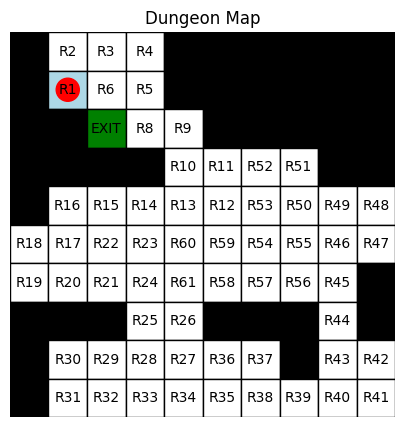

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:
right

You are currently in: The Dungeon


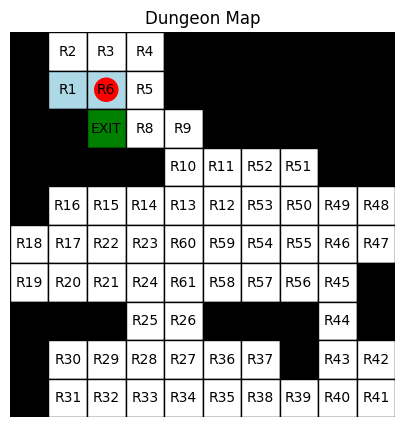

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:
down
You found the exit! Moving to the next level.

You are currently in: The Dungeon


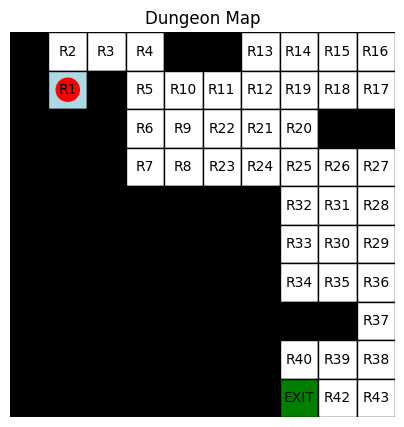

Dungeon Level: 2
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:
up

You are currently in: The Dungeon


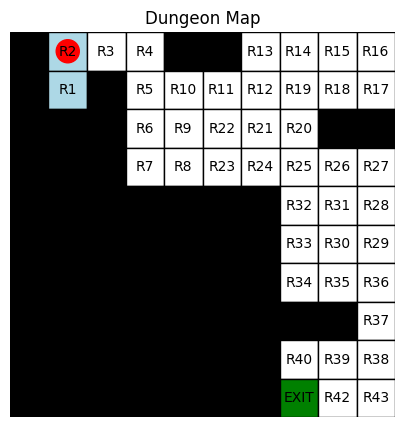

Dungeon Level: 2
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:
exit

You are currently in: The Village


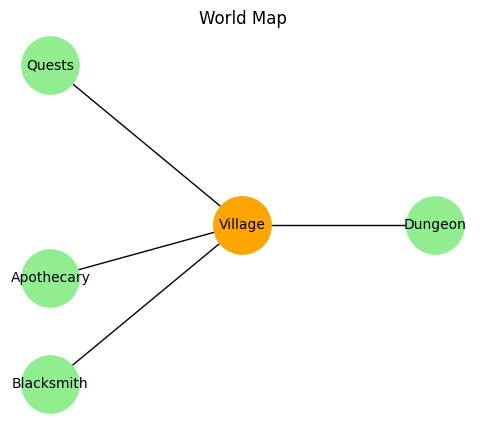

Where would you like to go?
quests

You are currently in: The Quests
Welcome to the Quest Board
Select one of the following quests.
1. Find the mirror of enchantment.
2. Defeat the vampire king.
3. Discover the unexplored tomb.
4. Save Game
Enter 1, 2, 3, 4 or exit to return to village.
4
Group: <__main__.Group object at 0x7c1e5fb6b9d0>
Current Location: Quests
Locations: None
Dungeon Map: {None, <__main__.DungeonMap object at 0x7c1e5fb6b070>}


KeyboardInterrupt: Interrupted by user

In [ ]:
def main():

    print("Welcome to the Dungeon Master AI Agent!")

    # Load game option
    load_choice = input("Would you like to load a previous game? (yes/no): ").strip().lower()
    group = None

    if load_choice == 'yes':
        group = load_game()  # Attempt to load the game
        if group is None:
            print("No saved game found. Proceeding to character creation.")
            group = group_creation()  # Create new group if loading fails
    else:
        group = group_creation()  # Create new group if not loading

    villageMap = GameMap()
    locations = createVillage(villageMap)
    level1 = DungeonMap(10, 10)  # 10x10 grid for the dungeon
    level2 = None  # Initialize level2 and level3 as None
    level3 = None

    dungeonMap = {level1, level2, level3}

    currentLocation = "Village"
    dungeonLevel = 1

    while True:
        print(f"\nYou are currently in: The {currentLocation}")

        # Current Location Dungeon
        if currentLocation == "Dungeon":
            if dungeonLevel == 1:
                level1.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")
            elif dungeonLevel == 2:
                if level2 is None:  # Create level2
                    level2 = DungeonMap(10, 10)
                level2.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")
            elif dungeonLevel == 3:
                if level3 is None:  # Create level3
                    level3 = DungeonMap(10, 10)
                level3.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")

            print("Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:")
            command = input().lower()

            if command in ['up', 'down', 'left', 'right']:
                if dungeonLevel == 1 and level1.movePlayer(command):
                    if level1.playerPos == level1.exitPos:
                        print("You found the exit! Moving to the next level.")
                        dungeonLevel += 1
                elif dungeonLevel == 2 and level2.movePlayer(command):
                    if level2.playerPos == level2.exitPos:
                        print("You found the exit! Moving to the next level.")
                        dungeonLevel += 1
                    elif level2.playerPos == level2.startPos:  # Move back to Level 1
                        print("Moving back to Level 1.")
                        dungeonLevel -= 1
                elif dungeonLevel == 3 and level3.movePlayer(command):
                    if level3.playerPos == level3.exitPos:
                        print("You finished your quest. Congratulations!")
                        # Clear current dungeon levels before returning to village
                        level1 = None
                        level2 = None
                        level3 = None
                        currentLocation = "Village"
                    elif level3.playerPos == level3.startPos:  # Move back to Level 2
                        print("Moving back to Level 2.")
                        dungeonLevel -= 1
                else:
                    print("Invalid move. Try again.")
            elif command == 'exit':
                currentLocation = "Village"
            else:
                print("Invalid command. Please enter a valid direction or 'exit'.")
        elif currentLocation == "Quests":
          Quest.processQuest()
          print(f"Enter 1, 2, 3, 4 or exit to return to village.")
          command = input().lower()
          if command == '4':
            print(f"Group: {group}")
            print(f"Current Location: {currentLocation}")
            print(f"Locations: {locations}")
            print(f"Dungeon Map: {dungeonMap}")
            save_game(group, currentLocation, locations, dungeonMap)
          if command in ['1', '2', '3']:
            print("Quest Accepted")
            # TO DO LOGIC
            currentLocation = "Dungeon"
          elif command == 'exit':
            currentLocation = "Village"
          else:
            print("Invalid quest. Please choose a valid quest.")
        elif currentLocation == "Blacksmith":
          Blacksmith.processBlacksmith()
          choice = input().lower()
          if(choice == 'exit'):
            currentLocation = "Village"
          elif(choice == '1'):
            Blacksmith.processWeapon()
            choice = input().lower()
            if(choice == 'exit'):
              currentLocation = "Village"
          elif(choice == '2'):
            Blacksmith.processArmour()
            choice = input().lower()
            if(choice == 'exit'):
              currentLocation = "Village"
          else:
            print("Invalid choice. Please choose a valid option.")
        elif currentLocation == "Apothecary":
          Apothecary.processApothecary()
          print(f"Enter 1, 2, or exit to return to village.")
          command = input().lower()
          if command in ['1', '2']:
            print("Accepted")
          elif command == 'exit':
            currentLocation = "Village"
          else:
            print("Invalid quest. Please choose a valid quest.")
        else:
            villageMap.drawMap(currentLocation)
            print("Where would you like to go?")
            command = input().strip().capitalize()

            if command in villageMap.locations:
                currentLocation = command
            elif command.lower() == "exit":
                print("Exiting the game.")
                break
            else:
                print("Invalid location. Please choose a valid destination.")

        plt.close()  # Close the current plot before drawing the next one

if __name__ == "__main__":
    main()

In [ ]:
# Generate Text
def generateText(prompt):
  response = openai.ChatCompletion.create(
      model="gpt-o4-mini",
      messages=[
          {"role":, "user", "content": prompt}
      ]
  )
  return response['choices'][0]['message']['content']

In [ ]:
# Test for text generation
prompt = "Write a short story about nature."
result = generatText(prompt)
print(result)

In [ ]:
def userInput(userInput):
  #Random Image generation to 20%
  if random.random() < 0.4:
    imagePrompt = f"D&D scene: {userInput}"
    imageURL = generateImage(imagePrompt)
    return f"Here's what that looks like: {imageURL}"
  return "Regular response without image"

In [ ]:
def main():
  print("Welcome to the Dungeon Master Agent! (Type 'quit' to exit)")
  while True:
    userText = input("What would you like to do? ")
    if userText.lower() == 'quit':
      print("Thanks for playing!")
      break

    response = userInput(userText)
    print(response)

if __name__ == "__main__":
    main()

Welcome to the Dungeon Master Agent! (Type 'quit' to exit)
What would you like to do? I want to visit a DnD village


NameError: name 'random' is not defined